In [1]:
''' RNN Bidireccional en Keras '''
__author__ = '@Tssp'
import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
from scipy import ndimage
# Keras NN:
from keras.layers import Conv2D, Input, Dense, MaxPooling2D, UpSampling2D, Flatten
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.utils import to_categorical
# My utils:
from codvidutils.imageproc import map_categorical
from codvidutils.cudasession import set_session

Using TensorFlow backend.


In [2]:
#set_session(ngpu=1, ncpu=4)
set_session()

Num GPUs Available:  2
Num CPUs Available:  7
---------Keras session created with---------
 - 2 GPUs
 - 7 CPUs


In [3]:
train_class = pd.read_csv('data/train_split_v2.txt', sep=' ', header=None, names=['patientID', 'image_path', 'class'])
test_class = pd.read_csv('data/test_split_v2.txt', sep=' ', header=None, names=['patientID', 'image_path', 'class'])

In [4]:
values_dict = {'pneumonia': 1, 'COVID-19': 0, 'normal': 1}
test_class['class_categorical'] = test_class['class'].apply(map_categorical, args=(values_dict,))
train_class['class_categorical'] = train_class['class'].apply(map_categorical, args=(values_dict,))

In [5]:
train_pics = []
for img in train_class['image_path'].values:
    train_pics.append(np.array(Image.open('data/train/' + img))[:, :, :3])
test_pics = []
for img in test_class['image_path'].values:
    test_pics.append(np.array(Image.open('data/test/' + img))[:, :, :3])

# Input data

In [6]:
X_train = np.array(train_pics)
del train_pics
X_test = np.array(test_pics)
del test_pics
diseaseID_train = np.asarray(train_class["class_categorical"])
diseaseID_test = np.asarray(test_class["class_categorical"])
print('Train shape X: {},  Y: {} \n Test shape X: {}, Y: {}'
      .format(X_train.shape, diseaseID_train.shape, X_test.shape, diseaseID_test.shape))

Train shape X: (16574, 200, 200, 3),  Y: (16574,) 
 Test shape X: (1953, 200, 200, 3), Y: (1953,)


## We create new images zooming 

(200, 200, 3)


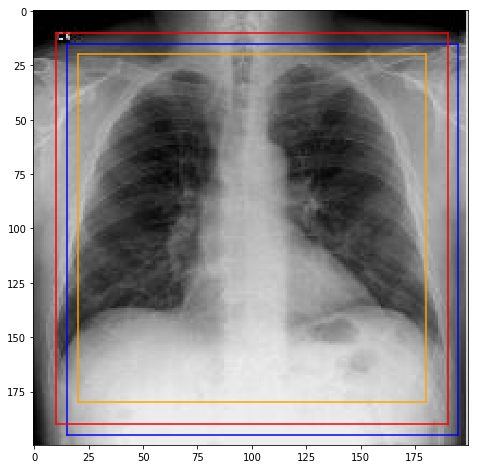

In [7]:
a = X_test[diseaseID_test==0][5]
print(a.shape)
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,8))#,
rotate_face = ndimage.rotate(a, -0,reshape=False)
plt.imshow(rotate_face)


plt.plot([15,195],[15,15],color="blue")
plt.plot([15,195],[195,195],color="blue")
plt.plot([195,195],[15,195],color="blue")
plt.plot([15,15],[15,195],color="blue")

plt.plot([10,190],[10,10],color="red")
plt.plot([10,190],[190,190],color="red")
plt.plot([190,190],[10,190],color="red")
plt.plot([10,10],[10,190],color="red")

plt.plot([20,180],[20,20],color="orange")
plt.plot([20,180],[180,180],color="orange")
plt.plot([180,180],[20,180],color="orange")
plt.plot([20,20],[20,180],color="orange")